In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import pickle, sys
import boto3
import pathlib, json
import torch

sys.path.append('../scripts/')
from attention_extractor import get_attention_weights, TCRModel, Explain_TCRModel
from analysis_util import get_mat_from_result_tuple
import plotly.express as px

sys.path.append('../')
sys.path.append('../..')
from sklearn.model_selection import KFold
from recipes.dataset import MCPASDataset

# Ignite
sys.path.append('../scripts/')
from analysis_util import get_mat_from_result_tuple
from ignite.engine import Events, create_supervised_trainer
from ignite.handlers import Checkpoint
from matplotlib import pyplot as plt

import sys
sys.path.append('./../streamlit/')
from streamlit_utils import get_df, cleanup, HHB_COLUMNS, read_hhb_file, read_hhb_text, process_hhb

def get_donoar_acceptor(pdbid):
    df = read_hhb_file(pdbid)
    data_donors_n_acceptors = [read_hhb_text(row.item()) for i, row in df.iterrows()]
    data_donors_n_acceptors = [a for a in data_donors_n_acceptors if a is not None]
    df_donor_acceptor = pd.DataFrame(data_donors_n_acceptors)
    df_donor_acceptor = process_hhb(df_donor_acceptor)
    return df_donor_acceptor

loading....
ending... loading....


100%|██████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]
28it [00:00, 65.88it/s]

2OL3 has only delta-chain and beta-chain


65it [00:01, 57.62it/s]

4QRR has only delta-chain and beta-chain
5JHD has only delta-chain and beta-chain
5JZI has only delta-chain and beta-chain


79it [00:01, 53.26it/s]
/Users/kyoheikoyama/.pyenv/versions/miniconda3-latest/envs/tcrpred/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [3]:
pd.set_option('display.max_columns', 500)


# Recover model

In [4]:
MAXLENGTH_A, MAXLENGTH_B, max_len_epitope = 28, 28, 25

KFOLD_I = 3

def get_file_paths(bucket, dirname, feat_name, extension='.parquet'):
    dataroot = f"s3://{bucket}/"
    objs = boto3.resource("s3").Bucket(f"{bucket}").objects.filter(
        Prefix=f"{dirname}/{feat_name}")
    files = [obj.key for obj in objs
             if not obj.key.startswith(f"{dirname}.ipynb_checkpoints") and obj.key.endswith(extension)]
    files = [os.path.join(dataroot, f) for f in files]
    return files


def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

# os.system(f'''aws s3 sync {CHECKPOINT_DIR}/ ./../../../checkpoint/{dt}/''')
# os.system(f'''aws s3 sync s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/{dt}_results_attention_tra.pickle ./../../hhyylog/''')


# Example sequences

In [5]:
df_vdjdb_original_train = get_df_from_path([f'../analysis/../../external_data/ERGO-II/Samples/vdjdb_no10x_train_samples.pickle'])
df_mcpas_original_train = get_df_from_path([f'../analysis/../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle'])
dataset_vdjdb_train = MCPASDataset(df_vdjdb_original_train).data
dataset_mcpas_train = MCPASDataset(df_mcpas_original_train).data
dataset_vdjdb_train = dataset_vdjdb_train.assign(split='train')
dataset_mcpas_train = dataset_mcpas_train.assign(split='train')
df_vdjdb_original_test = get_df_from_path([f'../analysis/../../external_data/ERGO-II/Samples/vdjdb_no10x_test_samples.pickle'])
df_mcpas_original_test = get_df_from_path([f'../analysis/../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle'])
dataset_vdjdb_test = MCPASDataset(df_vdjdb_original_test).data
dataset_mcpas_test = MCPASDataset(df_mcpas_original_test).data
dataset_vdjdb_test = dataset_vdjdb_test.assign(split='test')
dataset_mcpas_test = dataset_mcpas_test.assign(split='test')

dataset_vdjdb = pd.concat([dataset_vdjdb_test, dataset_vdjdb_train])
dataset_mcpas = pd.concat([dataset_mcpas_test, dataset_mcpas_train])

del dataset_mcpas_test, dataset_mcpas_train, dataset_vdjdb_test, dataset_vdjdb_train

datasize and y-vcounts:  (19526, 11) 0    16266
1     3260
Name: sign, dtype: int64
datasize and y-vcounts:  (23363, 11) 0    19472
1     3891
Name: sign, dtype: int64
datasize and y-vcounts:  (4485, 11) 0    3742
1     743
Name: sign, dtype: int64
datasize and y-vcounts:  (5611, 11) 0    4673
1     938
Name: sign, dtype: int64


../recipes/dataset.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sign'] = df['sign'].astype(int)


In [6]:
dataset_vdjdb.shape, dataset_mcpas.shape

((24011, 12), (28974, 12))

In [7]:
dataset_vdjdb.head(2)

,tcrb,tcra,va,ja,vb,jb,peptide,protein,mhc,t_cell_type,sign,split
0,CATRIGWGTDTQYF,CAVRDTNTNAGKSTF,TRAV1-1*01,NaN,TRBV5-1*01,TRBJ2-3*01,DPFRLLQNSQVFS,NP,HLA-DRA*01,MHCI,0,test
1,CTCSAGTGGFNYAEQFF,CAVSSYGSSGNKLIF,TRAV9N-3*01,TRAJ32*01,TRBV1*01,TRBJ2-1*01,KAFSPEVIPMF,Gag,HLA-B*57:01,MHCI,0,test


# Get attention from adhoc sequence

## Recover model weights

In [9]:
device = 'cpu'

with open(f"../hpo_params/optuna_best.json", "r") as fp:
    hparams = json.load(fp)

# fix random seeds
seed = 9
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
with open(f'../hpo_params/optuna_best.json', 'r') as fp:
    hparams = json.load(fp)

d_model, d_ff, n_head,n_local_encoder,n_global_encoder = hparams['d_model'], hparams['d_ff'], hparams['n_head'], hparams['n_local_encoder'], hparams['n_global_encoder']
dropout=hparams['dropout']
early_stopping_target = "pr_auc_on_one"
batch_size = hparams['batch_size']
lr=hparams['lr']

n_tok = 29  # NUM_VOCAB
n_pos1 = 62  # MAX_LEN_AB (sum of maxlens of a and b)
n_pos2 = 26  # MAX_LEN_Epitope
n_seg = 3

'''Model, optim, trainer'''
model = TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                 n_tok=n_tok, n_pos1=n_pos1,
                n_pos2=n_pos2, n_seg=n_seg,)

explain_model = Explain_TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                                 n_tok=n_tok, n_pos1=n_pos1, n_pos2=n_pos2, n_seg=n_seg)
explain_model.load_state_dict(model.state_dict(), strict=False)

model.to(device)
explain_model = explain_model.to(device)

model = model.eval()
explain_model = explain_model.eval()


# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Loss
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 15.0], device=device))

trainer = create_supervised_trainer(
    model=model, optimizer=optim, loss_fn=loss_fn, device=device,
)

FNAME ='../scripts/dir_kicker/logs/files_20220212_200237_alldata.csv'
INTERGER_SELECTOR = 1
logdf = pd.read_csv(FNAME)
dt = logdf.checkp[INTERGER_SELECTOR].split('/')[-1]

checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if dt in f]
CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'
CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

## Get the prediction and the best model
to_load = {'model': model, 'optimizer': optim, 'trainer': trainer}
torch_check_point_local = '../../../checkpoint/'
fro = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATH)
if not os.path.exists(os.path.join(torch_check_point_local, CHECKPOINT_PATH)):
    os.system(f'''aws s3 cp {fro} {torch_check_point_local}''')
    
checkpoint = torch.load(os.path.join(torch_check_point_local, CHECKPOINT_PATH), 
                        map_location=torch.device(device))
checkpoint['trainer']['seed'] = 9

Checkpoint.load_objects(to_load=to_load, checkpoint=checkpoint)


In [14]:
CHECKPOINT_PATH

'best_20220211_191951_checkpoint_100_pr_auc_on_one=0.7924.pt'

In [13]:
torch_check_point_local

'../../../checkpoint/'

In [11]:
checkpoint_files

['s3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_060552/best_20211012_060552_checkpoint_100_pr_auc_on_one=0.4897.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_060552/best_20211012_060552_checkpoint_99_pr_auc_on_one=0.4861.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063152/best_20211012_063152_checkpoint_96_pr_auc_on_one=0.9461.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063152/best_20211012_063152_checkpoint_97_pr_auc_on_one=0.9470.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063156/best_20211012_063156_checkpoint_96_pr_auc_on_one=0.9461.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063156/best_20211012_063156_checkpoint_97_pr_auc_on_one=0.9470.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063201/best_20211012_063201_checkpoint_96_pr_auc_on_one=0.9461.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20211012_063201/best_20211012_063201

## Put data in dataloader

In [ ]:
# ONLY_HEAD_ZERO = True
ONLY_HEAD_ZERO = False

def _get_tuple_result(alpha, beta, pep):
    df = pd.DataFrame({'sign':1, 'tcra':alpha,'tcrb':beta, 'peptide':pep}, 
                      index=[0])

    torch_dataset = MCPASDataset(df)
    analysis_loader = torch.utils.data.DataLoader(torch_dataset)

    with torch.no_grad():
        for i, (xx,yy) in enumerate(analysis_loader):
            result_tuple = get_attention_weights([x.to(device) for x in xx], 
                                           model, explain_model=explain_model, device=device)

    # result_tuple[0].shape, result_tuple[1].shape, result_tuple[2]
    
    return result_tuple
    
    
def get_attended(alpha, beta, pep):
    result_tuple = _get_tuple_result(alpha, beta, pep)
    print('prediction =',result_tuple[2])
    attention_pep4_tcr4 = get_mat_from_result_tuple(result_tuple, alpha,beta,pep)
    
    if ONLY_HEAD_ZERO == True:
        attention_tcr4 = [(attention_pep4_tcr4[1][i] > attention_pep4_tcr4[1][i].values.ravel().mean() + 4.5 * attention_pep4_tcr4[1][i].values.ravel().std())
                          for i in range(1)]
        attention_pep4 = [(attention_pep4_tcr4[0][i] > attention_pep4_tcr4[0][i].values.ravel().mean() + 5.5 * attention_pep4_tcr4[0][i].values.ravel().std())
                      for i in range(1)]
    else:
        attention_tcr4 = [(attention_pep4_tcr4[1][i] > attention_pep4_tcr4[1][i].values.ravel().mean() + 4.5 * attention_pep4_tcr4[1][i].values.ravel().std())
                          for i in range(4)]
        attention_pep4 = [(attention_pep4_tcr4[0][i] > attention_pep4_tcr4[0][i].values.ravel().mean() + 5.5 * attention_pep4_tcr4[0][i].values.ravel().std())
                      for i in range(4)]
    attended_tcrs = pd.concat(attention_tcr4).any()
    attended_peps = pd.concat(attention_pep4).any()
    return attended_tcrs, attended_peps

def get_attended_prediction(alpha, beta, pep):
    result_tuple = _get_tuple_result(alpha, beta, pep)
    return result_tuple[2]


# Main

## 1

### Increased peptide contacts govern high affinity binding of a modified TCR whilst maintaining a native pMHC docking mode

Supplementary

- https://www.frontiersin.org/articles/file/downloadfile/54043_supplementary-materials_datasheets_2_pdf/octet-stream/Data%20Sheet%202.PDF/1/54043


Main Doc
- https://www.frontiersin.org/articles/10.3389/fimmu.2013.00168/full#h5

PDB
- https://www.rcsb.org/sequence/1AO7

- alpha:D, beta:E

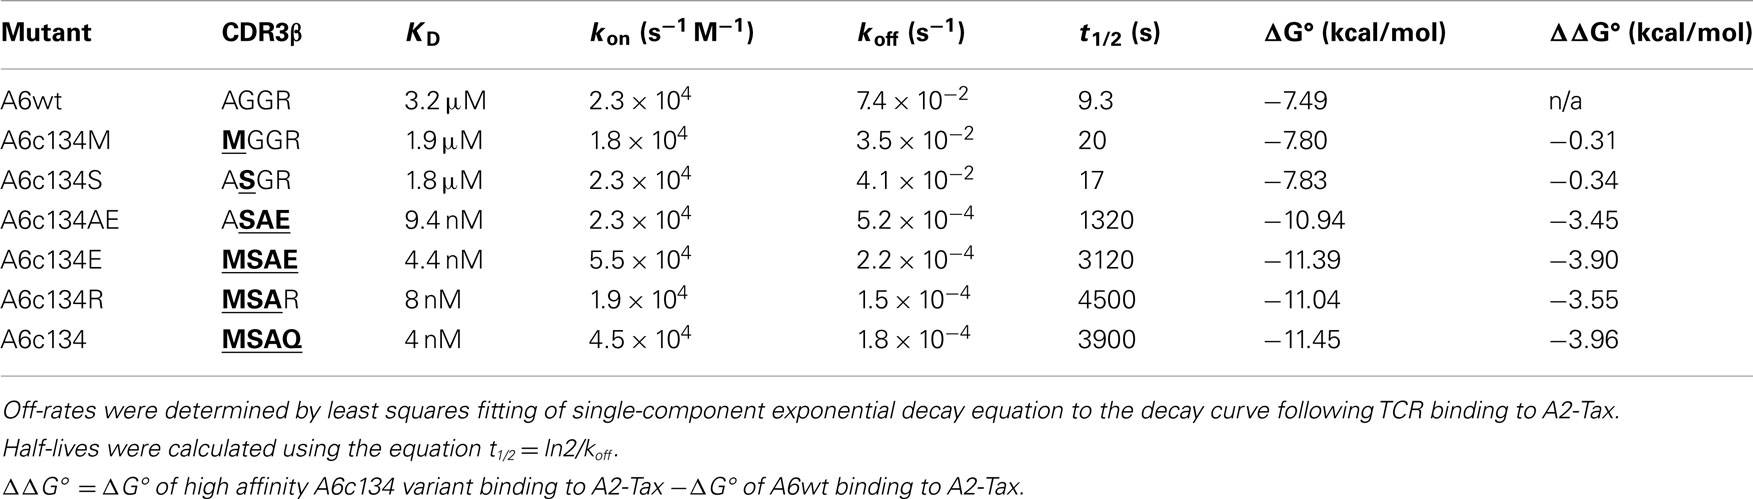

## 1ao7  (Before Mutation)


In [54]:
def show_matrix(
    cdr_alpha, cdr_beta, peptide,
                alphachain = 'I',
                betachain = 'J',
                epitopechain = 'C',
                alpha_begins= 91, alpha_ends =106,
                beta_begins = 91, beta_ends = 105,
                pdbid = '5TEZ',
                cdrs = None,                
               ):
    
    # Initialize two empty lists to hold the elements
    first_list = []
    second_list = []

    # Iterate over each element in the original list until the colon
    for element in cdrs[:cdrs.index(":")]:
        first_list.append(element)

    # Iterate over each element in the original list from the colon to the end
    for element in cdrs[cdrs.index(":")+1:]:
        second_list.append(element)
    print(first_list, second_list)

    HbondsCDR_list = []
    Hbonds_list = []
    HbondsPep_list = []

    df_donor_acceptor = get_donoar_acceptor(pdbid)
    print('resname, #hbond, #hbond_cdrs')
#     for ii in range(alpha_begins, alpha_ends):
#         res = f'{alphachain}0{ii:03d}'
    for res in first_list:
        bonds = df_donor_acceptor[
            (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
        Hbonds_list.append(len(bonds))
        bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
        bonds_cdrs = bonds_cdrs.query(
            '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
        bonds_pep = bonds.query(f'donor_chain_identifier=="{epitopechain}" or acceptor_chain_identifier=="{epitopechain}"')
        HbondsCDR_list.append(len(bonds_cdrs))
        HbondsPep_list.append(len(bonds_pep))

    Hbonds_list.append(":")
    HbondsCDR_list.append(":")
    HbondsPep_list.append(":")

    print('')
    print('resname, #hbond, #hbond_cdrs')
#     for ii in range(beta_begins, beta_ends):
#     res = f'{betachain}0{ii:03d}'
    for res in second_list:
        bonds = df_donor_acceptor[
            (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]    
        Hbonds_list.append(len(bonds))
        bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
        bonds_cdrs = bonds_cdrs.query(
            '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
        bonds_pep = bonds.query(f'donor_chain_identifier=="{epitopechain}" or acceptor_chain_identifier=="{epitopechain}"')
        HbondsCDR_list.append(len(bonds_cdrs))
        HbondsPep_list.append(len(bonds_pep))

    attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
    temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
    temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

    temp['cdrs'] = cdrs
    temp['#Hbonds'] = Hbonds_list
    temp['#Hbonds_cdr_self'] = HbondsCDR_list
    temp['#HbondsPep'] = HbondsPep_list

    temp2 = temp.copy()
    temp2['is_attention_large'] = temp2['is_attention_large'].map({True:'L', False:'S'})
    temp2 = temp2[['AA_type', 'is_attention_large', '#Hbonds', '#Hbonds_cdr_self', '#HbondsPep']]\
        .reset_index(drop=True).set_index('AA_type')

    display(temp.T) #, attended_peps
    display(temp2.T)
    display(px.imshow(attended_tcrs.to_frame().T, 
                      aspect="auto",
                      height=200
                     ))
    plt.show()
    display(attended_peps.to_frame().T) #, attended_peps



In [56]:
pdbid = '1AO7'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'
cdr_beta = 'CASRPGLAGGRP'

alpha_begins = 90
alpha_ends = 102
alpha_tickers = [90,91,92,93,98,99,100,101,102]
beta_begins = 92
beta_ends = 103
beta_tickers = [92,93,94,95,96,97,98,99,100,101,102, 103]

assert len(cdr_alpha) == len(alpha_tickers) 
assert len(cdr_beta) == len(beta_tickers) 

cdrs = [f'{alphachain}0{ii:03d}' for ii in alpha_tickers] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in beta_tickers]


show_matrix(cdr_alpha, cdr_beta, peptide, alphachain,
                betachain,
                epitopechain,
                alpha_begins, alpha_ends,
                beta_begins, beta_ends,
                pdbid,
                cdrs,
               )


['D0090', 'D0091', 'D0092', 'D0093', 'D0098', 'D0099', 'D0100', 'D0101', 'D0102'] ['E0092', 'E0093', 'E0094', 'E0095', 'E0096', 'E0097', 'E0098', 'E0099', 'E0100', 'E0101', 'E0102', 'E0103']
resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9993483424186707
aseq=CAVTTDSWG, bseq=CASRPGLAGGRP, peptide=LLFGYPVYV


,C_0,A_1,V_2,T_3,T_4,D_5,S_6,W_7,G_8,:_9,C_10,A_11,S_12,R_13,P_14,G_15,L_16,A_17,G_18,G_19,R_20,P_21
is_attention_large,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
AA_type,C,A,V,T,T,D,S,W,G,:,C,A,S,R,P,G,L,A,G,G,R,P
cdrs,D0090,D0091,D0092,D0093,D0098,D0099,D0100,D0101,D0102,:,E0092,E0093,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103
#Hbonds,1,2,2,3,2,5,2,2,3,:,1,2,4,6,1,0,2,1,0,2,1,2
#Hbonds_cdr_self,1,0,2,0,1,3,0,1,1,:,0,0,2,2,0,0,0,1,0,0,1,2
#HbondsPep,0,0,0,0,0,0,2,0,0,:,0,0,0,1,0,0,1,0,0,0,0,0


AA_type,C,A,V,T,T,D,S,W,G,:,C,A,S,R,P,G,L,A,G,G,R,P
is_attention_large,S,S,L,S,S,S,S,S,L,S,S,S,S,S,S,S,S,S,S,S,S,S
#Hbonds,1,2,2,3,2,5,2,2,3,:,1,2,4,6,1,0,2,1,0,2,1,2
#Hbonds_cdr_self,1,0,2,0,1,3,0,1,1,:,0,0,2,2,0,0,0,1,0,0,1,2
#HbondsPep,0,0,0,0,0,0,2,0,0,:,0,0,0,1,0,0,1,0,0,0,0,0


,L_0,L_1,F_2,G_3,Y_4,P_5,V_6,Y_7,V_8
0,False,False,False,False,False,False,False,False,False


In [20]:

HbondsCDR_list = []
Hbonds_list = []
df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for ii in alpha_tickers:
    res = f'{alphachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    #display(bonds)
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

Hbonds_list.append(":")
HbondsCDR_list.append(":")

print('')
print('resname, #hbond, #hbond_cdrs')
for ii in beta_tickers:
    res = f'{betachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    
    Hbonds_list.append(len(bonds))
    
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
temp['cdrs'] = cdrs
temp['#Hbonds'] = Hbonds_list
temp['#Hbonds_cdr'] = HbondsCDR_list
temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

display(temp.T) #, attended_peps
display(px.imshow(attended_tcrs.to_frame().T, 
                  aspect="auto",
                  height=200
                 ))
plt.show()
display(attended_peps.to_frame().T) #, attended_peps


resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9993483424186707
aseq=CAVTTDSWG, bseq=CASRPGLAGGRP, peptide=LLFGYPVYV


,C_0,A_1,V_2,T_3,T_4,D_5,S_6,W_7,G_8,:_9,...,S_12,R_13,P_14,G_15,L_16,A_17,G_18,G_19,R_20,P_21
is_attention_large,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
cdrs,D0090,D0091,D0092,D0093,D0098,D0099,D0100,D0101,D0102,:,...,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103
#Hbonds,1,2,2,3,2,5,2,2,3,:,...,4,6,1,0,2,1,0,2,1,2
#Hbonds_cdr,1,0,2,0,1,3,0,1,1,:,...,2,2,0,0,0,1,0,0,1,2
AA_type,C,A,V,T,T,D,S,W,G,:,...,S,R,P,G,L,A,G,G,R,P


,L_0,L_1,F_2,G_3,Y_4,P_5,V_6,Y_7,V_8
0,False,False,False,False,False,False,False,False,False


## 4ftv (After Mutation)


In [21]:
pdbid = '4FTV'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'
cdr_beta = 'CASRPGLAGGRP'.replace('AGGR', 'MSAQ')

alpha_begins = 90
alpha_ends = 102
alpha_tickers = [90,91,92,93,98,99,100,101,102]
beta_begins = 92
beta_ends = 103
beta_tickers = [92,93,94,95,96,97,98,99,100,101,102, 103]

assert len(cdr_alpha) == len(alpha_tickers) 
assert len(cdr_beta) == len(beta_tickers) 

cdrs = [f'{alphachain}0{ii:03d}' for ii in alpha_tickers] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in beta_tickers]


HbondsCDR_list = []
Hbonds_list = []
df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for ii in alpha_tickers:
    res = f'{alphachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    #display(bonds)
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

Hbonds_list.append(":")
HbondsCDR_list.append(":")

print('')
print('resname, #hbond, #hbond_cdrs')
for ii in beta_tickers:
    res = f'{betachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    
    Hbonds_list.append(len(bonds))
    
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
temp['cdrs'] = cdrs
temp['#Hbonds'] = Hbonds_list
temp['#Hbonds_cdr'] = HbondsCDR_list
temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

display(temp.T) #, attended_peps
display(px.imshow(attended_tcrs.to_frame().T, 
                  aspect="auto",
                  height=200
                 ))
plt.show()
display(attended_peps.to_frame().T) #, attended_peps


resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9865899085998535
aseq=CAVTTDSWG, bseq=CASRPGLMSAQP, peptide=LLFGYPVYV


,C_0,A_1,V_2,T_3,T_4,D_5,S_6,W_7,G_8,:_9,...,S_12,R_13,P_14,G_15,L_16,M_17,S_18,A_19,Q_20,P_21
is_attention_large,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
cdrs,D0090,D0091,D0092,D0093,D0098,D0099,D0100,D0101,D0102,:,...,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103
#Hbonds,2,2,2,4,2,8,3,1,2,:,...,4,7,1,1,1,0,1,1,1,2
#Hbonds_cdr,1,0,2,1,1,4,0,1,1,:,...,2,2,0,0,0,0,1,0,1,2
AA_type,C,A,V,T,T,D,S,W,G,:,...,S,R,P,G,L,M,S,A,Q,P


,L_0,L_1,F_2,G_3,Y_4,P_5,V_6,Y_7,V_8
0,False,False,False,False,True,False,False,False,False


In [23]:
%%capture
# stop
pred_result = []
peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'
letters= 'ACDEFGHIKLMNPQRSTVWY'

for x in letters:
    mutation = f'CASRPGLMSA{x}P'.upper()
    p = get_attended_prediction(
        cdr_alpha,
        mutation, 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

<BarContainer object of 20 artists>

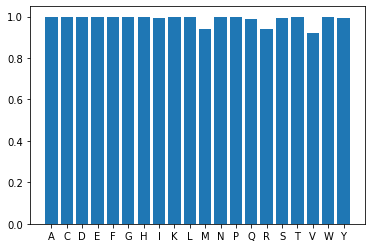

In [24]:
plt.bar(list(letters), pred_result)

In [25]:
%%capture
# stop
pred_result = []
peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'

for x in letters:
    mutation = f'CASRPGLMS{x}QP'.upper()
    p = get_attended_prediction(
        cdr_alpha,
        mutation, 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

<BarContainer object of 20 artists>

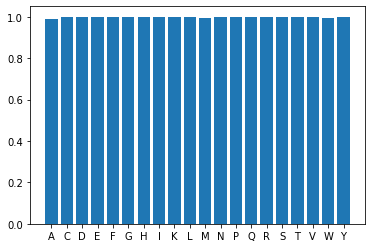

In [26]:
plt.bar(list(letters), pred_result)

In [27]:
%%capture
# stop
pred_result = []
peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'

for x in letters:
    p = get_attended_prediction(
        f'CAVT{x}DSWG'.upper(),
        f'CASRPGLMSAQP'.upper(), 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

<BarContainer object of 20 artists>

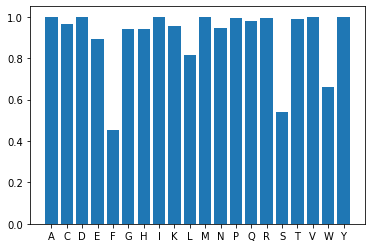

In [28]:
plt.bar(list(letters), pred_result)

In [29]:
%%capture
# stop
pred_result = []
peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'

for x in letters:
    p = get_attended_prediction(
        cdr_alpha,
        f'CAS{x}PGLMSAQP'.upper(), 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

<BarContainer object of 20 artists>

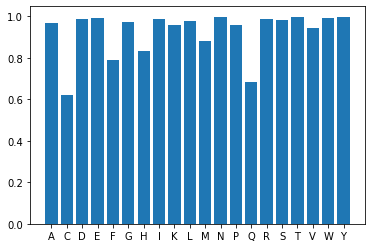

In [30]:
plt.bar(list(letters), pred_result)

In [31]:
%%capture
# stop
pred_result = []
peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'

for x in letters:
    p = get_attended_prediction(
        f'CAVTTDSW{x}'.upper(),
        f'CASRPGLMSAQP', 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

<BarContainer object of 20 artists>

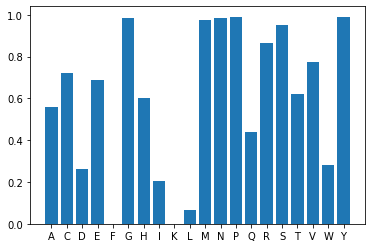

In [32]:
plt.bar(list(letters), pred_result)

## PyMol Command

In [33]:
# %%capture
pdbid = '1ao7'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

alpha_begins = 92
alpha_ends = 101
beta_begins = 90
beta_ends = 102

peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'
cdr_beta = 'CASRPGLAGGRP'

cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

len(cdr_alpha) + len(cdr_beta) + 1, len(cdrs), cdrs

(22,
 22,
 ['D0092',
  'D0093',
  'D0094',
  'D0095',
  'D0096',
  'D0097',
  'D0098',
  'D0099',
  'D0100',
  ':',
  'E0090',
  'E0091',
  'E0092',
  'E0093',
  'E0094',
  'E0095',
  'E0096',
  'E0097',
  'E0098',
  'E0099',
  'E0100',
  'E0101'])

In [34]:

print('-'*30)
print(f"""
fetch {pdbid};
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain {alphachain}) and not solvent;
select beta, (chain {betachain}) and not solvent;
select mhc, (chain {mhcchain}) and not solvent;
select epitope, (chain {epitopechain}) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;

""")
print('-'*30)



------------------------------

fetch 1ao7;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain D) and not solvent;
select beta, (chain E) and not solvent;
select mhc, (chain A) and not solvent;
select epitope, (chain C) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;


------------------------------


In [35]:
pdbid = '4ftv'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

alpha_begins = 92
alpha_ends = 101
beta_begins = 90
beta_ends = 102

peptide = 'LLFGYPVYV'
cdr_alpha = 'CAVTTDSWG'
cdr_beta = 'CASRPGLMSAQP'

cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

# len(cdr_alpha) + len(cdr_beta) + 1, len(cdrs), cdrs

In [36]:

print('-'*30)
print(f"""
fetch {pdbid};
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain {alphachain}) and not solvent;
select beta, (chain {betachain}) and not solvent;
select mhc, (chain {mhcchain}) and not solvent;
select epitope, (chain {epitopechain}) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;

""")
print('-'*30)



------------------------------

fetch 4ftv;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain D) and not solvent;
select beta, (chain E) and not solvent;
select mhc, (chain A) and not solvent;
select epitope, (chain C) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;


------------------------------


# [Cell Molecular Therapy]

## Improving T Cell Receptor On-Target Specificity via Structure-Guided Design


In [40]:
# pdbid = '3QDG'

## 4L3E (After mutation)


In [58]:
# %%capture a
pdbid = '4L3E'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

alpha_begins = 88
alpha_ends = 102

beta_begins = 94
beta_ends = 109

cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

peptide = 'ELAGIGILTV'
cdr_alpha = 'CAVNFGGGKLIFGQ'
cdr_beta = 'CASSWSFGTEAFFGQ' #.replace('GGGTL', target)


In [59]:
len(cdrs)

30

In [60]:
show_matrix(cdr_alpha, cdr_beta, peptide,
            alphachain,
                betachain,
                epitopechain,
                alpha_begins, alpha_ends,
                beta_begins, beta_ends,
                pdbid,
                cdrs,
               )

['D0088', 'D0089', 'D0090', 'D0091', 'D0092', 'D0093', 'D0094', 'D0095', 'D0096', 'D0097', 'D0098', 'D0099', 'D0100', 'D0101'] ['E0094', 'E0095', 'E0096', 'E0097', 'E0098', 'E0099', 'E0100', 'E0101', 'E0102', 'E0103', 'E0104', 'E0105', 'E0106', 'E0107', 'E0108']
resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9990586638450623
aseq=CAVNFGGGKLIFGQ, bseq=CASSWSFGTEAFFGQ, peptide=ELAGIGILTV


,C_0,A_1,V_2,N_3,F_4,G_5,G_6,G_7,K_8,L_9,I_10,F_11,G_12,Q_13,:_14,C_15,A_16,S_17,S_18,W_19,S_20,F_21,G_22,T_23,E_24,A_25,F_26,F_27,G_28,Q_29
is_attention_large,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
AA_type,C,A,V,N,F,G,G,G,K,L,I,F,G,Q,:,C,A,S,S,W,S,F,G,T,E,A,F,F,G,Q
cdrs,D0088,D0089,D0090,D0091,D0092,D0093,D0094,D0095,D0096,D0097,D0098,D0099,D0100,D0101,:,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103,E0104,E0105,E0106,E0107,E0108
#Hbonds,1,2,2,5,3,1,1,2,1,2,2,0,1,3,:,2,2,4,5,2,4,1,1,2,0,2,2,0,1,1
#Hbonds_cdr_self,0,0,2,3,2,1,1,1,1,1,2,0,0,1,:,1,0,2,1,0,3,0,0,2,0,0,2,0,1,0
#HbondsPep,0,0,0,0,0,0,0,0,0,0,0,0,0,0,:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


AA_type,C,A,V,N,F,G,G,G,K,L,I,F,G,Q,:,C,A,S,S,W,S,F,G,T,E,A,F,F,G,Q
is_attention_large,S,S,S,S,S,S,L,S,S,L,S,S,S,L,S,S,S,S,S,S,S,S,S,S,S,S,L,S,S,L
#Hbonds,1,2,2,5,3,1,1,2,1,2,2,0,1,3,:,2,2,4,5,2,4,1,1,2,0,2,2,0,1,1
#Hbonds_cdr_self,0,0,2,3,2,1,1,1,1,1,2,0,0,1,:,1,0,2,1,0,3,0,0,2,0,0,2,0,1,0
#HbondsPep,0,0,0,0,0,0,0,0,0,0,0,0,0,0,:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,E_0,L_1,A_2,G_3,I_4,G_5,I_6,L_7,T_8,V_9
0,False,False,False,False,False,False,False,False,False,True


In [38]:

print(f"""
fetch {pdbid};
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain {alphachain}) and not solvent;
select beta, (chain {betachain}) and not solvent;
select mhc, (chain {mhcchain}) and not solvent;
select epitope, (chain {epitopechain}) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;
show sticks, epitope;
util.cbay epitope;

sel beta_cdr3, (chain {betachain} and resi {beta_begins}:{beta_ends});
set cartoon_side_chain_helper, on
show sticks, beta_cdr3;
util.cbag beta_cdr3;
sel alpha_cdr3, (chain {alphachain} and resi {alpha_begins}:{alpha_ends});
set cartoon_side_chain_helper, on
show sticks, alpha_cdr3;
util.cbag alpha_cdr3;

select cdr3, alpha_cdr3 or beta_cdr3;
select tcr, alpha or beta;
dist H_cdr_p, cdr3, epitope, mode=2;
hide labels, H_cdr_p;
color black, H_cdr_p;
dist H_cdr_tcr, cdr3, tcr, mode=2;
hide labels, H_cdr_tcr;
color grey, H_cdr_tcr;


sel atten_a_head1, (chain {alphachain} and resi 91);
color pink, atten_a_head1;
sel atten_a_head1, (chain {alphachain} and resi 89);
color pink, atten_a_head1;
sel atten_a_head1, (chain {alphachain} and resi 101);
color pink, atten_a_head1;
sel atten_a_head1, (chain {alphachain} and resi 99);
color pink, atten_a_head1;
sel atten_b_head0, (chain {betachain} and resi 107);
color pink, atten_b_head0;
""")


fetch 4L3E;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain D) and not solvent;
select beta, (chain E) and not solvent;
select mhc, (chain A) and not solvent;
select epitope, (chain C) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;
show sticks, epitope;
util.cbay epitope;

sel beta_cdr3, (chain E and resi 94:109);
set cartoon_side_chain_helper, on
show sticks, beta_cdr3;
util.cbag beta_cdr3;
sel alpha_cdr3, (chain D and resi 88:102);
set cartoon_side_chain_helper, on
show sticks, alpha_cdr3;
util.cbag alpha_cdr3;

select cdr3, alpha_cdr3 or beta_cdr3;
select tcr, alpha or beta;
dist H_cdr_p, cdr3, epitope, mode=2;
hide labels, H_cdr_p;
color black, H_cdr_p;
dist H_cdr_tcr, cdr3, tcr, mode=2;
hide labels, H_cdr_tcr;
color grey, H_cdr_tcr;


sel atten_a_head1, 

In [39]:
%%capture b

HbondsCDR_list = []
Hbonds_list = []

df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for ii in range(alpha_begins, alpha_ends):
    res = f'{alphachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    #display(bonds)
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    print(res, len(bonds), len(bonds_cdrs) )
    
    HbondsCDR_list.append(len(bonds_cdrs))

Hbonds_list.append(":")
HbondsCDR_list.append(":")

print('')
print('resname, #hbond, #hbond_cdrs')
for ii in range(beta_begins, beta_ends):
    res = f'{betachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

In [40]:
print()

attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
temp['cdrs'] = cdrs
temp['#Hbonds'] = Hbonds_list
temp['#Hbonds_cdr'] = HbondsCDR_list
temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

display(temp.T) #, attended_peps
display(px.imshow(attended_tcrs.to_frame().T, 
                  aspect="auto",
                  height=200
                 ))
plt.show()
display(attended_peps.to_frame().T) #, attended_peps



datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9990586638450623
aseq=CAVNFGGGKLIFGQ, bseq=CASSWSFGTEAFFGQ, peptide=ELAGIGILTV


,C_0,A_1,V_2,N_3,F_4,G_5,G_6,G_7,K_8,L_9,I_10,F_11,G_12,Q_13,:_14,C_15,A_16,S_17,S_18,W_19,S_20,F_21,G_22,T_23,E_24,A_25,F_26,F_27,G_28,Q_29
is_attention_large,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
cdrs,D0088,D0089,D0090,D0091,D0092,D0093,D0094,D0095,D0096,D0097,D0098,D0099,D0100,D0101,:,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103,E0104,E0105,E0106,E0107,E0108
#Hbonds,1,2,2,5,3,1,1,2,1,2,2,0,1,3,:,2,2,4,5,2,4,1,1,2,0,2,2,0,1,1
#Hbonds_cdr,0,0,2,3,2,1,1,1,1,1,2,0,0,1,:,1,0,2,1,0,3,0,0,2,0,0,2,0,1,0


,E_0,L_1,A_2,G_3,I_4,G_5,I_6,L_7,T_8,V_9
0,False,False,False,False,False,False,False,False,False,True


## 3QDG (Before Mutation)

In [41]:
pdbid = '3QDG'

alphachain = 'D'
betachain = 'E'
epitopechain = 'C'
mhcchain = 'A'

alpha_begins = 88
alpha_ends = 102
beta_begins = 94
beta_ends = 109

peptide = 'ELAGIGILTV'
cdr_alpha = 'CAVNFGGGKLIFGQ'
cdr_beta = 'CASSLSFGTEAFFGQ' 
# cdr_beta = 'CASSWSFGTEAFFGQ'

cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)] + [':'] +\
[f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

print('-'*30)
print(f"""
fetch {pdbid};
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain {alphachain}) and not solvent;
select beta, (chain {betachain}) and not solvent;
select mhc, (chain {mhcchain}) and not solvent;
select epitope, (chain {epitopechain}) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;

""")
print('-'*30)

------------------------------

fetch 3QDG;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select alpha, (chain D) and not solvent;
select beta, (chain E) and not solvent;
select mhc, (chain A) and not solvent;
select epitope, (chain C) and not solvent;

show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;

show sticks, epitope;
util.cbay epitope;


------------------------------


In [42]:
cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)]
cdrs += [f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

HbondsCDR_list = []
Hbonds_list = []
df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for ii in range(alpha_begins, alpha_ends):
    res = f'{alphachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    #display(bonds)
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

Hbonds_list.append(":")
HbondsCDR_list.append(":")

print('')
print('resname, #hbond, #hbond_cdrs')
for ii in range(beta_begins, beta_ends):
    res = f'{betachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    
    Hbonds_list.append(len(bonds))
    
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    
    #print(res, len(bonds), len(bonds_cdrs) )
    HbondsCDR_list.append(len(bonds_cdrs))

attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
temp['cdrs'] = cdrs
temp['#Hbonds'] = Hbonds_list
temp['#Hbonds_cdr'] = HbondsCDR_list
temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

display(temp.T) #, attended_peps
display(px.imshow(attended_tcrs.to_frame().T, 
                  aspect="auto",
                  height=200
                 ))
plt.show()
display(attended_peps.to_frame().T) #, attended_peps


resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9909838438034058
aseq=CAVNFGGGKLIFGQ, bseq=CASSLSFGTEAFFGQ, peptide=ELAGIGILTV


,C_0,A_1,V_2,N_3,F_4,G_5,G_6,G_7,K_8,L_9,I_10,F_11,G_12,Q_13,:_14,C_15,A_16,S_17,S_18,L_19,S_20,F_21,G_22,T_23,E_24,A_25,F_26,F_27,G_28,Q_29
is_attention_large,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
cdrs,D0088,D0089,D0090,D0091,D0092,D0093,D0094,D0095,D0096,D0097,D0098,D0099,D0100,D0101,:,E0094,E0095,E0096,E0097,E0098,E0099,E0100,E0101,E0102,E0103,E0104,E0105,E0106,E0107,E0108
#Hbonds,1,2,2,3,2,0,1,1,1,2,2,0,1,1,:,2,2,4,5,2,5,1,1,2,0,2,2,0,2,1
#Hbonds_cdr,0,0,2,1,1,0,1,1,1,1,2,0,0,0,:,1,0,2,1,0,3,0,0,2,0,0,2,0,1,0


,E_0,L_1,A_2,G_3,I_4,G_5,I_6,L_7,T_8,V_9
0,False,False,False,False,False,False,False,False,False,True


In [43]:
bonds


,donor_res,donor_atom,acceptor_res,acceptor_atom,da_dist,donor_mainorside,acceptor_mainorside,gap,da_dist_inCAatoms,Angle_inHydrogen,Dist_bw_H_n_Acceptor,smaller_angle_in_A,smaller_angle_in_D,count,originaltext,AA_code_donor,AA_code_acceptor,donor_res_seq_num,acceptor_res_seq_num,donor_chain_identifier,acceptor_chain_identifier,donor_4digit,acceptor_4digit
510,3QDGE3QDG/E0108-GLN,NE2,E3QDG/E0007-ILE,O,2.75,S,M,1,7.81,123.8,2.06,131.4,141.8,511,3QDGE3QDG/E0108-GLN NE2 E3QDG/E0007-ILE O 2...,Q,I,108,7,E,E,E0108,E0007


In [44]:
%%capture
# stop
pred_result = []
letters = 'ACDEFGHIKLMNPQRSTVWY'
for x in letters:
    print(x)
    p = get_attended_prediction(
        f'CAVNFGGGKLIFG{x}'.upper(), 
        cdr_beta, 
        peptide)
    pred_result.append(p)

<BarContainer object of 20 artists>

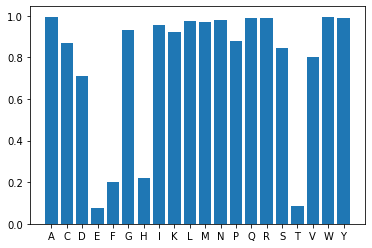

In [45]:
plt.bar(list(letters), pred_result)

In [46]:
%%capture
# stop
pred_result = []
for x in letters:
    print(x)
    p = get_attended_prediction(
        f'CAVNFGGG{x}LIFGQ'.upper(), 
        cdr_beta, 
        peptide)
    pred_result.append(p)

<BarContainer object of 20 artists>

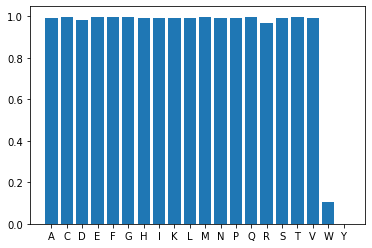

In [47]:
plt.bar(list(letters), pred_result)

In [48]:
%%capture
# stop
pred_result = []
for x in letters:
    print(x)
    p = get_attended_prediction(
        f'CAVNFGGGKLIFGQ'.upper(), 
        cdr_beta, 
        peptide)
    pred_result.append(p)

## To other atom types

In [49]:
cdr_alpha

'CAVNFGGGKLIFGQ'

In [50]:
%%capture
# stop
pred_result = []
letters= 'ACDEFGHIKLMNPQRSTVWY'
for x in letters:
    print(x)
    p = get_attended_prediction(
        cdr_alpha.replace('CAVN', f'CAV{x}'.upper()), 
        cdr_beta, 
        peptide)
    pred_result.append(p)

<BarContainer object of 20 artists>

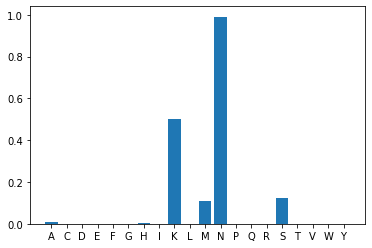

In [51]:
plt.bar(list(letters), pred_result)

In [52]:
cdr_alpha

'CAVNFGGGKLIFGQ'

In [53]:
%%capture a
# stop
pred_result = []
letters= 'ACDEFGHIKLMNPQRSTVWY'
for x in letters:
    mutation = cdr_beta.replace('CASSL', f'CASS{x}'.upper())
    p = get_attended_prediction(
        cdr_alpha, 
        mutation, 
        peptide)
    print(x, mutation)
    pred_result.append(p)
    

<BarContainer object of 20 artists>

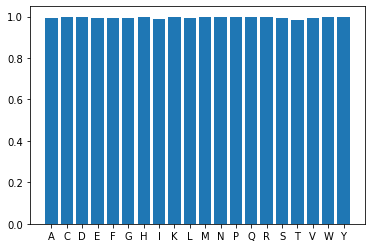

In [54]:
plt.bar(list(letters), pred_result)

In [55]:
%%capture a
# stop
pred_result = []
letters= 'ACDEFGHIKLMNPQRSTVWY'
for x in letters:
    mutation = cdr_beta.replace('CASSL', f'CA{x}SL'.upper())
    p = get_attended_prediction(
        cdr_alpha, 
        mutation, 
        peptide)
    print(x, mutation)
    pred_result.append(p)
    

<BarContainer object of 20 artists>

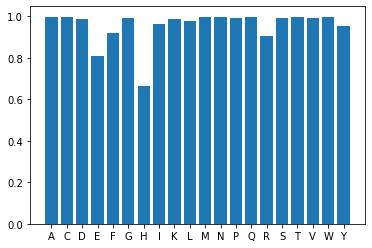

In [56]:
plt.bar(list(letters), pred_result)

In [57]:
%%capture a
# stop
pred_result = []
letters= 'ACDEFGHIKLMNPQRSTVWY'
for x in letters:
    mutation = cdr_beta.replace('CASSLS', f'CASSL{x}'.upper())
    p = get_attended_prediction(
        cdr_alpha, 
        mutation, 
        peptide)
    print(x, mutation)
    pred_result.append(p)
    

<BarContainer object of 20 artists>

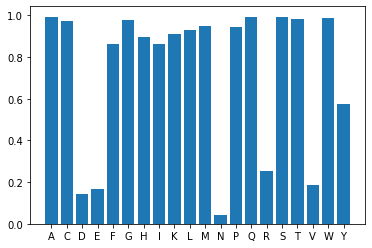

In [58]:
plt.bar(list(letters), pred_result)

# 5TEZ

## Q10

In [59]:
%%capture

# stop
pred_result = []
peptide = 'GILGFVFTL'

cdr_alpha= 'CAASFIIQGAQKLVF'
cdr_beta= 'CASSLLGGWSEAFF'

for x in letters:
    mutation =  f'CAASFIIQGA{x}KLVF'.upper()
    p = get_attended_prediction(
        mutation,
        cdr_beta,
        peptide
    )
    print(x, mutation)
    pred_result.append(p)
    

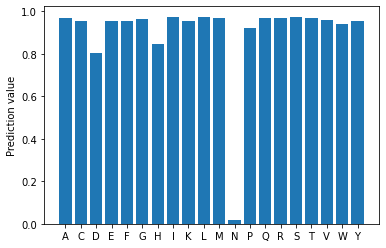

In [60]:
plt.bar(list(letters), pred_result)
# plt.title()
plt.ylabel('Prediction value')
plt.savefig('/Users/kyoheikoyama/workspace/TCRPrediction/papermaterials/inputperturbation_change_of_Q10.eps', format='eps')


## V13

In [61]:
%%capture

# stop
pred_result = []
peptide = 'GILGFVFTL'
cdr_alpha= 'CAASFIIQGAQKLVF'
cdr_beta= 'CASSLLGGWSEAFF'


for x in letters:
    mutation = cdr_alpha.replace(cdr_alpha, f'CAASFIIQGAQKL{x}F'.upper())
    p = get_attended_prediction(
        mutation, 
        cdr_beta,
        peptide
    )
    print(x, mutation, cdr_beta)
    pred_result.append(p)
    

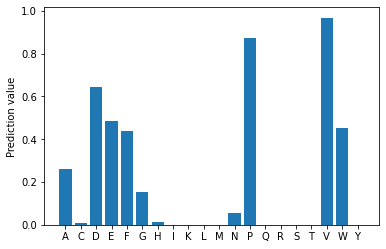

In [62]:
plt.bar(list(letters), pred_result)
# plt.title()
plt.ylabel('Prediction value')
plt.savefig('/Users/kyoheikoyama/workspace/TCRPrediction/papermaterials/inputperturbation_change_of_V13.eps', 
            format='eps')


## W24

In [63]:
%%capture
# stop
pred_result = []
peptide = 'GILGFVFTL'
cdr_alpha= 'CAASFIIQGAQKLVF'
cdr_beta= 'CASSLLGGWSEAFF'

for x in letters:
    mutation = cdr_beta.replace(cdr_beta, f'CASSLLGG{x}SEAFF'.upper())
    p = get_attended_prediction(
        cdr_alpha,
        mutation, 
        peptide
    )
    print(x, mutation, p, )
    pred_result.append(p)
    

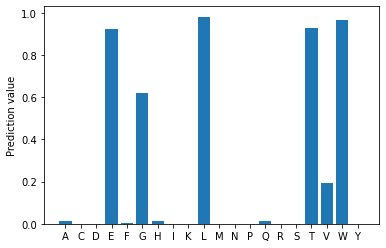

In [64]:
plt.bar(list(letters), pred_result)
# plt.title()
plt.ylabel('Prediction value')
plt.savefig('/Users/kyoheikoyama/workspace/TCRPrediction/papermaterials/inputperturbation_change_of_W24.eps', 
            format='eps')


## Matrix view


```
fetch 5TEZ;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
hide all;
select beta, chain J and not solvent;
select alpha, chain I and not solvent;
select mhc, (chain A or chain B or chain D or chain E) and not solvent;
show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;
sel beta_cdr3, (chain J and resi 91:104);
set cartoon_side_chain_helper, on
show sticks, beta_cdr3;
util.cbag beta_cdr3;
sel alpha_cdr3, (chain I and resi 91:105);
set cartoon_side_chain_helper, on
show sticks, alpha_cdr3;
util.cbag alpha_cdr3;
sel epitope, chain C and not solvent;
show sticks, epitope;
util.cbay epitope;
select cdr3, alpha_cdr3 or beta_cdr3;
select tcr, alpha or beta;
dist H_cdr_p, cdr3, epitope, mode=2;
hide labels, H_cdr_p;
color black, H_cdr_p;
dist H_cdr_tcr, cdr3, tcr, mode=2;
hide labels, H_cdr_tcr;
color grey, H_cdr_tcr;
sel atten_a_head1, (chain I and resi 104);
color pink, atten_a_head1;
sel atten_a_head2, (chain I and resi 101);
color pink, atten_a_head2;
sel atten_a_head3, (chain I and resi 101);
color pink, atten_a_head3;
sel atten_b_head0, (chain J and resi 99);
color pink, atten_b_head0;

```

In [80]:
alphachain = 'I'
betachain = 'J'
epitopechain = 'C'
alpha_begins, alpha_ends = 91, 106
beta_begins, beta_ends = 91,105
pdbid = '5TEZ'


cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)]
cdrs += [":"]
cdrs += [f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

cdrs = cdrs 

HbondsCDR_list = []
Hbonds_list = []
HbondsPep_list = []

df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for ii in range(alpha_begins, alpha_ends):
    res = f'{alphachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    bonds_pep = bonds.query(f'donor_chain_identifier=="{epitopechain}" or acceptor_chain_identifier=="{epitopechain}"')
    HbondsCDR_list.append(len(bonds_cdrs))
    HbondsPep_list.append(len(bonds_pep))

Hbonds_list.append(":")
HbondsCDR_list.append(":")
HbondsPep_list.append(":")

print('')
print('resname, #hbond, #hbond_cdrs')
for ii in range(beta_begins, beta_ends):
    res = f'{betachain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]    
    Hbonds_list.append(len(bonds))
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    bonds_pep = bonds.query(f'donor_chain_identifier=="{epitopechain}" or acceptor_chain_identifier=="{epitopechain}"')
    HbondsCDR_list.append(len(bonds_cdrs))
    HbondsPep_list.append(len(bonds_pep))

attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
temp = attended_tcrs.to_frame().rename(columns={0:'is_attention_large'})
temp['AA_type'] = temp.reset_index()['index'].apply(lambda x: x.split('_')[0]).values

temp['cdrs'] = cdrs
temp['#Hbonds'] = Hbonds_list
temp['#Hbonds_cdr_self'] = HbondsCDR_list
temp['#HbondsPep'] = HbondsPep_list

temp2 = temp

display(temp.T) #, attended_peps
display(px.imshow(attended_tcrs.to_frame().T, 
                  aspect="auto",
                  height=200
                 ))
plt.show()
display(attended_peps.to_frame().T) #, attended_peps



resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9673783779144287
aseq=CAASFIIQGAQKLVF, bseq=CASSLLGGWSEAFF, peptide=GILGFVFTL


,C_0,A_1,A_2,S_3,F_4,I_5,I_6,Q_7,G_8,A_9,Q_10,K_11,L_12,V_13,F_14,:_15,C_16,A_17,S_18,S_19,L_20,L_21,G_22,G_23,W_24,S_25,E_26,A_27,F_28,F_29
is_attention_large,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
AA_type,C,A,A,S,F,I,I,Q,G,A,Q,K,L,V,F,:,C,A,S,S,L,L,G,G,W,S,E,A,F,F
cdrs,I0091,I0092,I0093,I0094,I0095,I0096,I0097,I0098,I0099,I0100,I0101,I0102,I0103,I0104,I0105,:,J0091,J0092,J0093,J0094,J0095,J0096,J0097,J0098,J0099,J0100,J0101,J0102,J0103,J0104
#Hbonds,2,1,2,4,2,1,2,2,2,2,5,3,3,2,2,:,2,2,4,5,3,4,2,3,4,8,6,2,2,3
#Hbonds_cdr_self,1,0,2,1,2,0,2,0,0,2,1,3,1,2,0,:,1,0,2,2,0,3,0,0,1,4,0,0,2,0
#HbondsPep,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,:,0,0,0,0,0,0,0,0,1,0,0,0,0,0


,G_0,I_1,L_2,G_3,F_4,V_5,F_6,T_7,L_8
0,False,False,False,False,False,False,False,False,False


In [89]:
alphachain = 'I'
betachain = 'J'
epitopechain = 'C'
alpha_begins, alpha_ends = 91, 106
beta_begins, beta_ends = 91,105
pdbid = '5TEZ'


cdrs = [f'{alphachain}0{ii:03d}' for ii in range(alpha_begins, alpha_ends)]
cdrs += [":"]
cdrs += [f'{betachain}0{ii:03d}' for ii in range(beta_begins, beta_ends)]

cdrs = cdrs 



In [92]:
show_matrix(alphachain = 'I',
                betachain = 'J',
                epitopechain = 'C',
                alpha_begins= 91, alpha_ends =106,
                beta_begins = 91, beta_ends = 105,
                pdbid = '5TEZ',
               )

resname, #hbond, #hbond_cdrs

resname, #hbond, #hbond_cdrs
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9673783779144287
aseq=CAASFIIQGAQKLVF, bseq=CASSLLGGWSEAFF, peptide=GILGFVFTL


,C_0,A_1,A_2,S_3,F_4,I_5,I_6,Q_7,G_8,A_9,Q_10,K_11,L_12,V_13,F_14,:_15,C_16,A_17,S_18,S_19,L_20,L_21,G_22,G_23,W_24,S_25,E_26,A_27,F_28,F_29
is_attention_large,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
AA_type,C,A,A,S,F,I,I,Q,G,A,Q,K,L,V,F,:,C,A,S,S,L,L,G,G,W,S,E,A,F,F
cdrs,I0091,I0092,I0093,I0094,I0095,I0096,I0097,I0098,I0099,I0100,I0101,I0102,I0103,I0104,I0105,:,J0091,J0092,J0093,J0094,J0095,J0096,J0097,J0098,J0099,J0100,J0101,J0102,J0103,J0104
#Hbonds,2,1,2,4,2,1,2,2,2,2,5,3,3,2,2,:,2,2,4,5,3,4,2,3,4,8,6,2,2,3
#Hbonds_cdr_self,1,0,2,1,2,0,2,0,0,2,1,3,1,2,0,:,1,0,2,2,0,3,0,0,1,4,0,0,2,0
#HbondsPep,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,:,0,0,0,0,0,0,0,0,1,0,0,0,0,0


AA_type,C,A,A,S,F,I,I,Q,G,A,Q,K,L,V,F,:,C,A,S,S,L,L,G,G,W,S,E,A,F,F
is_attention_large,S,S,S,S,S,S,S,S,S,S,L,S,S,L,S,S,S,S,S,S,S,S,S,S,L,S,S,S,S,S
#Hbonds,2,1,2,4,2,1,2,2,2,2,5,3,3,2,2,:,2,2,4,5,3,4,2,3,4,8,6,2,2,3
#Hbonds_cdr_self,1,0,2,1,2,0,2,0,0,2,1,3,1,2,0,:,1,0,2,2,0,3,0,0,1,4,0,0,2,0
#HbondsPep,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,:,0,0,0,0,0,0,0,0,1,0,0,0,0,0


,G_0,I_1,L_2,G_3,F_4,V_5,F_6,T_7,L_8
0,False,False,False,False,False,False,False,False,False


# pdbid = '1G6R'

## https://doi.org/10.1016/j.jmb.2004.11.057

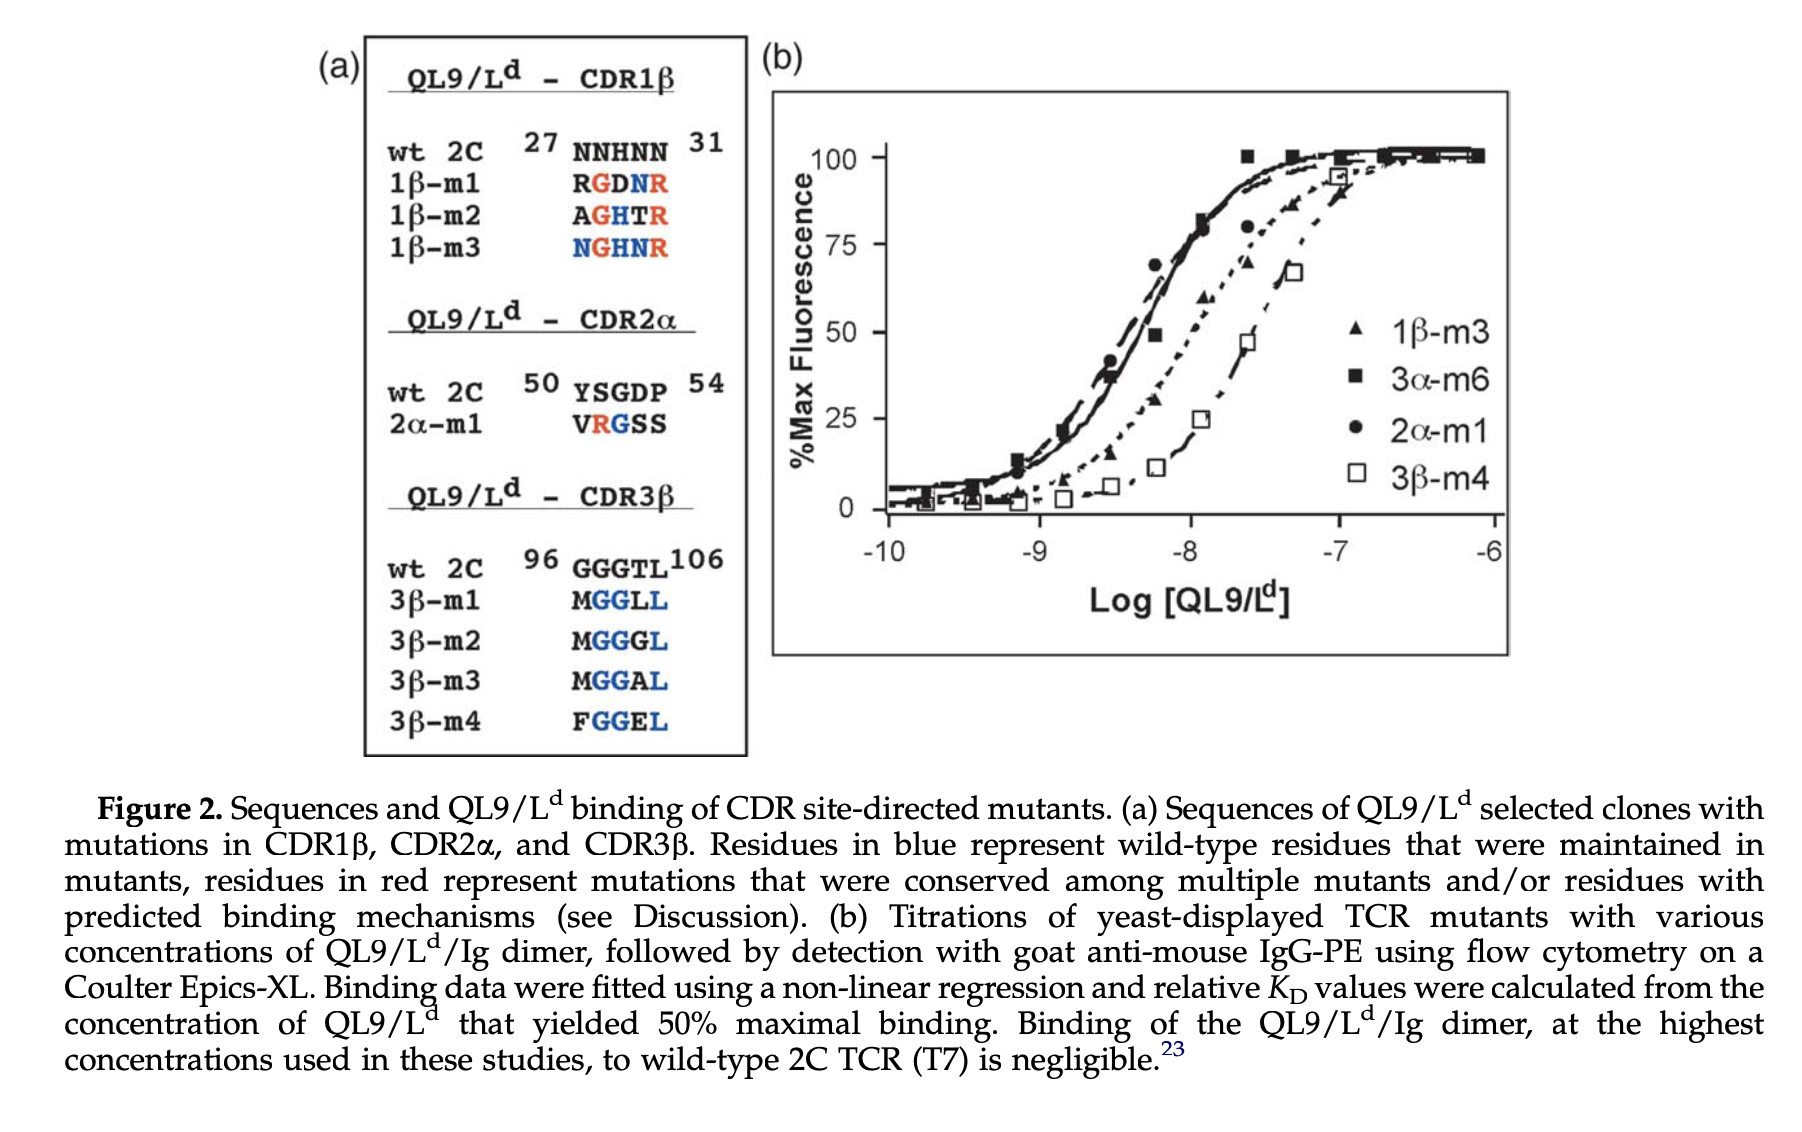

In [37]:
# temp = attended_tcrs.to_frame()
cdrs = ['A0090',
 'A0091',
 'A0092',
 'A0093',
#  '-',
#  '-',
#  '-',
#  '-',
#  '-',
 'A0099',
 'A0100',
 'A0101',
 'A0102',
 'A0103',
 'A0104',
 'A0105',
 'A0106'] + [':'] + ['B0092',
 'B0093',
 'B0094',
 'B0095',
 'B0096',
 'B0097',
 'B0098',
#  '-',
#  '-',
#  '-',
#  '-',
#  '-',
#  '-',
 'B0105',
 'B0106',
 'B0107',
 'B0108',
 'B0109']


In [33]:
for target in ['GGGTL', 'MGGLL', 'MGGGL', 'MGGAL', 'FGGEL']:
    print()
    peptide = 'SIYRYYGL'
    cdr_alpha = 'CAVSGFASALTF'
    cdr_beta = 'CASGGGGTLYFG'.replace('GGGTL', target)
    attended_tcrs, attended_peps = get_attended(cdr_alpha, cdr_beta, peptide)
    temp = attended_tcrs.to_frame()
    temp['cdrs'] = cdrs
    display(temp.T) #, attended_peps
    display(px.imshow(attended_tcrs.to_frame().T, 
                      aspect="auto",
                      height=200
                     ))
    display(attended_peps.to_frame().T) #, attended_peps
    


datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.8370179533958435
aseq=CAVSGFASALTF, bseq=CASGGGGTLYFG, peptide=SIYRYYGL


,C_0,A_1,V_2,S_3,G_4,F_5,A_6,S_7,A_8,L_9,T_10,F_11,:_12,C_13,A_14,S_15,G_16,G_17,G_18,G_19,T_20,L_21,Y_22,F_23,G_24
0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True
cdrs,A0090,A0091,A0092,A0093,A0099,A0100,A0101,A0102,A0103,A0104,A0105,A0106,:,B0092,B0093,B0094,B0095,B0096,B0097,B0098,B0105,B0106,B0107,B0108,B0109


,S_0,I_1,Y_2,R_3,Y_4,Y_5,G_6,L_7
0,False,False,False,True,False,False,False,False



datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.16658736765384674
aseq=CAVSGFASALTF, bseq=CASGMGGLLYFG, peptide=SIYRYYGL


,C_0,A_1,V_2,S_3,G_4,F_5,A_6,S_7,A_8,L_9,T_10,F_11,:_12,C_13,A_14,S_15,G_16,M_17,G_18,G_19,L_20,L_21,Y_22,F_23,G_24
0,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,True
cdrs,A0090,A0091,A0092,A0093,A0099,A0100,A0101,A0102,A0103,A0104,A0105,A0106,:,B0092,B0093,B0094,B0095,B0096,B0097,B0098,B0105,B0106,B0107,B0108,B0109


,S_0,I_1,Y_2,R_3,Y_4,Y_5,G_6,L_7
0,False,False,False,False,False,False,False,False



datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.0670538991689682
aseq=CAVSGFASALTF, bseq=CASGMGGGLYFG, peptide=SIYRYYGL


,C_0,A_1,V_2,S_3,G_4,F_5,A_6,S_7,A_8,L_9,T_10,F_11,:_12,C_13,A_14,S_15,G_16,M_17,G_18,G_19,G_20,L_21,Y_22,F_23,G_24
0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,True
cdrs,A0090,A0091,A0092,A0093,A0099,A0100,A0101,A0102,A0103,A0104,A0105,A0106,:,B0092,B0093,B0094,B0095,B0096,B0097,B0098,B0105,B0106,B0107,B0108,B0109


,S_0,I_1,Y_2,R_3,Y_4,Y_5,G_6,L_7
0,False,False,False,False,False,False,False,False



datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.0001559270458528772
aseq=CAVSGFASALTF, bseq=CASGMGGALYFG, peptide=SIYRYYGL


,C_0,A_1,V_2,S_3,G_4,F_5,A_6,S_7,A_8,L_9,T_10,F_11,:_12,C_13,A_14,S_15,G_16,M_17,G_18,G_19,A_20,L_21,Y_22,F_23,G_24
0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,True
cdrs,A0090,A0091,A0092,A0093,A0099,A0100,A0101,A0102,A0103,A0104,A0105,A0106,:,B0092,B0093,B0094,B0095,B0096,B0097,B0098,B0105,B0106,B0107,B0108,B0109


,S_0,I_1,Y_2,R_3,Y_4,Y_5,G_6,L_7
0,False,False,False,False,False,False,False,False



datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
prediction = 0.9536359310150146
aseq=CAVSGFASALTF, bseq=CASGFGGELYFG, peptide=SIYRYYGL


,C_0,A_1,V_2,S_3,G_4,F_5,A_6,S_7,A_8,L_9,T_10,F_11,:_12,C_13,A_14,S_15,G_16,F_17,G_18,G_19,E_20,L_21,Y_22,F_23,G_24
0,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,True,False,False,True
cdrs,A0090,A0091,A0092,A0093,A0099,A0100,A0101,A0102,A0103,A0104,A0105,A0106,:,B0092,B0093,B0094,B0095,B0096,B0097,B0098,B0105,B0106,B0107,B0108,B0109


,S_0,I_1,Y_2,R_3,Y_4,Y_5,G_6,L_7
0,False,False,False,False,False,False,False,False


In [38]:
len(cdr_beta)

12

In [35]:
# %%capture a

pdbid = '1G6R'

alpha_chain = 'A'
beta_chain = 'B'

cdrs = [f'{alpha_chain}0{ii:03d}' for ii in range(90,108)]
cdrs += [":"]
cdrs += [f'{beta_chain}0{ii:03d}' for ii in range(92,120)]

df_donor_acceptor = get_donoar_acceptor(pdbid)
print('resname, #hbond, #hbond_cdrs')
for i in range(18):
    ii = 90 + i
    res = f'{alpha_chain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    #display(bonds)
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    print(res, len(bonds), len(bonds_cdrs))
    
print('')
print('resname, #hbond, #hbond_cdrs')
for i in range(18):
    ii = 92 + i
    res = f'{beta_chain}0{ii:03d}'
    bonds = df_donor_acceptor[
        (df_donor_acceptor[['donor_4digit','acceptor_4digit']] == res).any(axis=1)]
    bonds_cdrs = bonds.query('donor_chain_identifier==acceptor_chain_identifier')
    bonds_cdrs = bonds_cdrs.query(
        '((donor_res_seq_num > 88) and (donor_res_seq_num < 108)) and ((acceptor_res_seq_num > 88) and (acceptor_res_seq_num < 108))')
    print(res, len(bonds), len(bonds_cdrs) )
    

resname, #hbond, #hbond_cdrs
A0090 1 0
A0091 2 0
A0092 2 2
A0093 3 1
A0094 0 0
A0095 0 0
A0096 0 0
A0097 0 0
A0098 0 0
A0099 1 0
A0100 1 0
A0101 1 0
A0102 3 1
A0103 0 0
A0104 2 0
A0105 2 2
A0106 0 0
A0107 0 0

resname, #hbond, #hbond_cdrs
B0092 1 0
B0093 2 0
B0094 2 2
B0095 1 1
B0096 0 0
B0097 1 1
B0098 0 0
B0099 0 0
B0100 0 0
B0101 0 0
B0102 0 0
B0103 0 0
B0104 0 0
B0105 0 0
B0106 1 0
B0107 2 2
B0108 0 0
B0109 1 0


In [39]:
"""
fetch 1G6R;
set seq_view, 1;
bg_color white;
set_color blue60, [ 0, 0, 110 ];
set_color blue30, [ 0, 0, 20 ];
set_color red60, [ 110, 0, 0 ];
set_color red30, [ 20, 0, 0 ];
# hide all;
select alpha, (chain A or chain F) and not solvent;
select beta, (chain B or chain G) and not solvent;
select mhc, (chain H or chain C or chain I or chain D) and not solvent;


show ribbon, alpha;
color salmon, alpha;
show ribbon, beta;
color cyan, beta;
show ribbon, mhc;
color grey70, mhc;
sel epitope, (chain E or chain J or chain P or chain Q) and not solvent;
show sticks, epitope;
util.cbay epitope;



sel beta_cdr3, (chain B and resi 92:120);
set cartoon_side_chain_helper, on
show sticks, beta_cdr3;
util.cbag beta_cdr3;
sel alpha_cdr3, (chain A and resi 90:108);
set cartoon_side_chain_helper, on
show sticks, alpha_cdr3;
util.cbag alpha_cdr3;

select cdr3, alpha_cdr3 or beta_cdr3;
select tcr, alpha or beta;
dist H_cdr_p, cdr3, epitope, mode=2;
hide labels, H_cdr_p;
color black, H_cdr_p;
dist H_cdr_tcr, cdr3, tcr, mode=2;
hide labels, H_cdr_tcr;
color grey, H_cdr_tcr;

# sel atten_a_head1, (chain D and resi 91);
# color pink, atten_a_head1;
# sel atten_a_head1, (chain D and resi 100);
# color pink, atten_a_head1;
# sel atten_b_head0, (chain E and resi 97);
# color pink, atten_b_head0;
# sel atten_b_head0, (chain E and resi 98);
# color pink, atten_b_head0;
# sel atten_b_head0, (chain E and resi 100);
# color pink, atten_b_head0;
"""

'\nfetch 1G6R;\nset seq_view, 1;\nbg_color white;\nset_color blue60, [ 0, 0, 110 ];\nset_color blue30, [ 0, 0, 20 ];\nset_color red60, [ 110, 0, 0 ];\nset_color red30, [ 20, 0, 0 ];\n# hide all;\nselect alpha, (chain A or chain F) and not solvent;\nselect beta, (chain B or chain G) and not solvent;\nselect mhc, (chain H or chain C or chain I or chain D) and not solvent;\n\n\nshow ribbon, alpha;\ncolor salmon, alpha;\nshow ribbon, beta;\ncolor cyan, beta;\nshow ribbon, mhc;\ncolor grey70, mhc;\nsel epitope, (chain E or chain J or chain P or chain Q) and not solvent;\nshow sticks, epitope;\nutil.cbay epitope;\n\n\n\nsel beta_cdr3, (chain B and resi 92:120);\nset cartoon_side_chain_helper, on\nshow sticks, beta_cdr3;\nutil.cbag beta_cdr3;\nsel alpha_cdr3, (chain A and resi 90:108);\nset cartoon_side_chain_helper, on\nshow sticks, alpha_cdr3;\nutil.cbag alpha_cdr3;\n\nselect cdr3, alpha_cdr3 or beta_cdr3;\nselect tcr, alpha or beta;\ndist H_cdr_p, cdr3, epitope, mode=2;\nhide labels, H_cdr